### Logistic Regression을 위한 Gradient Descent(경사 하강법)

## 목표
In this lab, you will:
- logistic regression을 위한 Gradient Descent 갱신
- 친숙한 데이터 세트에 경사 하강법 적용하는 것을 탐구

In [1]:
import copy, math
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from lab_utils_common import  dlc, plot_data, plt_tumor_data, sigmoid, compute_cost_logistic
from plt_quad_logistic import plt_quad_logistic, plt_prob
plt.style.use('deeplearning.mplstyle')

In [2]:
X_train = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_train = np.array([0, 0, 0, 1, 1, 1])

이전에서 처음 데이터를 가지고 그림을 그린다. 
label  𝑦=1인 데이터는 빨간색으로 x를 적용하고 𝑦=0 인 데이터에는 파란색 원을 적용함.

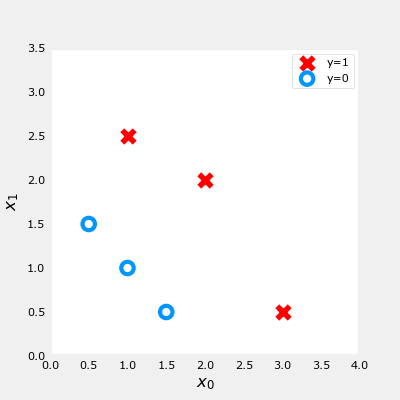

In [3]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_data(X_train, y_train, ax)

ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('$x_1$', fontsize=12)
ax.set_xlabel('$x_0$', fontsize=12)
plt.show()

## Logistic Gradient Descent
<img align="right" src="./images/C1_W3_Logistic_gradient_descent.png"     style=" width:400px; padding: 10px; " >

미분 계산을 활용하는 경사 하강법 알고리즘 상기
$$\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1} \\ 
&  \; \; \;  \; \;b = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
&\rbrace
\end{align*}$$

$w_j$ 모든 $j$ 에 대해서 동시에 갱신을 수행함. 여기에서
$$\begin{align*}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3} 
\end{align*}$$

* m 은 데이터 집합에서의 학습 데이터의 수
* $f_{\mathbf{w},b}(x^{(i)})$ 은 모델(linear regression)에서 출력된 예측값, $y^{(i)}$ 은 정답(label, target)
* 로지스틱 회귀 모델에서 $z = \mathbf{w} \cdot \mathbf{x} + b$  
    $f_{\mathbf{w},b}(x) = g(z)$  
    이겨서 $g(z)$ 는 시그모이드 함수:  
    $g(z) = \frac{1}{1+e^{-z}}$

### Gradient Descent 구현
경사 하강 알고리즘 구현은 2개의 요소로 구성 : 
- 수식 (1)의 반복문 구현 . 이것은 `gradient_descent` 이고 실무에서는 선택사항.
- 현재의 기울기 계산은 , 위의 수식 (2,3) . `compute_gradient_logistic` 아래에서 구현. 

#### 기울기 계산, 코드 설명
모든 $w_j$ 와 $b$에 대하여 위의 수식 (2),(3)을 구현 .
이것을 구현하기 위해 다양한 방법이 있지만, 아래는 개괄적인 설명: 
- `dj_dw` 와 `dj_db` 를 누적하기 위해 변수를 초기화.
- 각각의 학습 데이터에 대하여 
    - 각각의 에러에 대하여 $g(\mathbf{w} \cdot \mathbf{x}^{(i)} + b) - \mathbf{y}^{(i)}$
    - 하나의 training 데이터, 각각의 입력 변수 $x_{j}^{(i)}$ 
        - 오차(error)를 입력($x_{j}^{(i)}$)과 곱하고 , `dj_dw`의 해당 성분에 더한다 (위의 수식 2)
    - `dj_db` 를 추가로 더함 (위의 수식 3)

- `dj_db` 와 `dj_dw` 를 총 데이터의 갯수 (m) 로 나눔.
- $\mathbf{x}^{(i)}$ 는 numpy 데이터 `X[i,:]` 또는 `X[i]` 와 $x_{j}^{(i)}$ 는 `X[i,j]`

In [4]:
def compute_gradient_logistic(X, y, w, b):
    """
        선형 회귀를 위한 기울기 계산 
        Args:
            X(ndarray(m, n)): n개의 feature를 가진 m개의 training(학습) 데이터
            y(ndarray(m, )): target(정답)
            w(ndarray(n, )): 우리가 찾고자 하는 파라미터(weight, parameter)
            b(스칼라): 우리가 찾고자 하는 파라미터(bais, y절편)
        Return:
            dj_dw(ndarray(n, )) cost를 w로 미분
            dj_db(스칼라) cost를 b로 미분
    """
    m, n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.
    
    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i], w) + b) # (n,)(n,) = 스칼라
        err_i = f_wb_i - y[i]
        for j in range(n):
            dj_dw[j] += err_i * X[i,j] # 스칼라
        dj_db += err_i
    dj_dw /= m  # (n,)
    dj_db /= m # 스칼라
    return dj_db, dj_dw

In [8]:
X_tmp = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_tmp = np.array([0, 0, 0, 1, 1, 1])
w_tmp = np.array([2.,3.])
b_tmp = 1.
dj_db_tmp, dj_dw_tmp = compute_gradient_logistic(X_tmp, y_tmp, w_tmp, b_tmp)
print(f"dj_db: {dj_db_tmp}")
print(f"dj_dw:{dj_dw_tmp.tolist()}")

dj_db: 0.49861806546328574
dj_dw:[0.498333393278696, 0.49883942983996693]


**Expected output**
``` 
dj_db: 0.49861806546328574
dj_dw: [0.498333393278696, 0.49883942983996693]
```

#### Gradient Descent 코드
위의 식 (1) 의 구현은 아래와 같다. 
위의 수식에 루틴에서의 함수를 위치시키고 비교하기 위해 잠시 멈추자. 

In [11]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters):
    """
        Batch(여러개의 데이터를 묶어서) 단위로 경사 하강법 수행 
        Args:
            X(ndarray(m, n)): n개의 feature를 가진 m개의 training(학습) 데이터
            y(ndarray(m, )): target(정답)
            w_in(ndarray(n, )): 우리가 찾고자 하는 파라미터(weight, parameter)
            b_in(스칼라): 우리가 찾고자 하는 파라미터(bais, y절편)
            alpha(float): 학습률(learing_rate)
            num_iters(스칼라): 경사 하강을 동작시키기 위한 반복 횟수
        Return:
            w(ndarray(n, )) 갱신된 파라미터의 값
            b(스칼라) 갱신된 파라미터의 값
    """
    J_history = [] # 나중에 그래프에 적용하기 위한 Cost(J)와 weight(파라미터 w의 모임)
    w = copy.deepcopy(w_in)
    b = b_in
    for i in range(num_iters):
        dj_db, dj_dw = computer_gradient_logistic(X, y, w, b)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        if i<100000:
            J_history.append(compute_cost_logistic(X, y, w, b))
        if i%math.ceil(num_iters/10) == 0:
                print(f"반복 {i:4d}: cost{J_history[-1]}   ")
    return w, b, J_history

In [21]:
w_tmp = np.zeros_like(X_train[0])
b_tmp = 0.
alpha = 0.1
iters = 10000
w_out, b_out, _ = gradient_descent(X_train, y_train, w_tmp, b_tmp, alpha, iters)
print(f"\n 갱신된 파라미터: w{w_out}, b{b_out}")

반복    0: cost0.684610468560574   
반복 1000: cost0.1590977666870457   
반복 2000: cost0.08460064176930078   
반복 3000: cost0.05705327279402531   
반복 4000: cost0.04290759421682   
반복 5000: cost0.03433847729884557   
반복 6000: cost0.02860379802212006   
반복 7000: cost0.02450156960879306   
반복 8000: cost0.02142370332569295   
반복 9000: cost0.019030137124109114   

 갱신된 파라미터: w[5.28 5.08], b-14.222409982019837


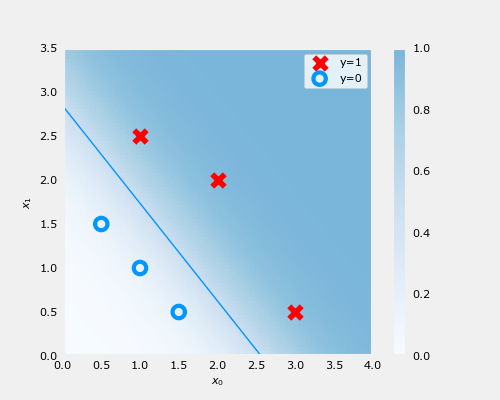

In [20]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
plt_prob(ax, w_out, b_out)

ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_0$')
ax.axis([0, 4, 0, 3.5])
plot_data(X_train, y_train, ax)
x0 = -b_out/w_out[0]
x1 = -b_out/w_out[1]
ax.plot([0,x0], [x1,0], c=dlc['dlblue'], lw=1)
plt.show()